In [1]:
import torch 
import matplotlib.pyplot as plt
from math import sqrt

from utils import *

In [2]:
levels = [4, 4]
m = sum(levels)
lamda = 0.2
min_distance = 0.1
array = NestedArray1D(lamda, min_distance, levels)

t = 4800
d = 9
snr = -10
theta = torch.arange(-4, 5, 1) * torch.pi / 12

sources_std = torch.eye(d, dtype=torch.complex64)
noise_std = torch.sqrt(torch.sum(torch.diag(sources_std) ** 2)) * 10 ** (- snr / 20)

X = array.get_steering_vector(theta) @ sources_std @ torch.randn(d, t, dtype=torch.complex64) / sqrt(2) \
  + noise_std * torch.randn(m, t, dtype=torch.complex64) / sqrt(2)

cov = X @ X.T.conj() / t
cov_vec = torch.flatten(cov)

In [3]:
dist = torch.Tensor([i - j for i in array.pos for j in array.pos])
vals, idx = torch.sort(dist)
first_occurence_index = []
min_idx = idx[0]

for i in range(1, vals.shape[0]):
    if vals[i] == vals[i - 1]:
        min_idx = min(min_idx, idx[i])
    else:
        first_occurence_index.append(min_idx)
        min_idx = idx[i]
first_occurence_index.append(min_idx)

first_occurence_index = torch.stack(first_occurence_index)
z = cov_vec[first_occurence_index]

In [4]:
# dist = torch.Tensor([i - j for i in array.pos for j in array.pos])
# vals, idx = torch.sort(dist)
# z = []

# for i in range(vals.shape[0]):
#     if i == 0:
#         z.append(cov_vec[idx[0]])
#         count = 1
#         continue
#     if vals[i] == vals[i - 1]:
#         z[-1] += cov_vec[idx[i]]
#         count += 1
#     else:
#         z[-1] /= count 
#         count = 1
#         z.append(cov_vec[idx[i]])
#     if i == vals.shape[0] - 1:
#         z[-1] /= count

# z = torch.stack(z)

In [5]:
len_subarray = array.pos[-1] - array.pos[0] + 1

coarray = ULA(lamda, min_distance, len_subarray)
coarray.build_array_manifold()

Rs = torch.zeros(len_subarray, len_subarray, dtype=torch.complex64)
for i in range(len_subarray):
    Rs += z[i : i + len_subarray].reshape(-1, 1) @ z[i : i + len_subarray].conj().reshape(1, -1)

Rs = Rs / sqrt(len_subarray)

vals, vecs = torch.linalg.eigh(Rs)
En = vecs[:, :(len_subarray - d)]
spectrum = 1 / torch.norm(En.T.conj() @ coarray.array_manifold, dim=0) ** 2

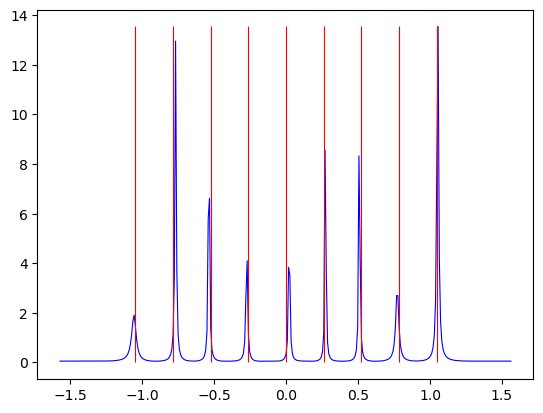

In [6]:
plt.plot(coarray.angles_spectrum, spectrum, linewidth=0.8, color='blue');
plt.vlines(theta, ymin=0, ymax=torch.max(spectrum), linewidth=0.8, color='red');